# Email Ham-Spam Classification

Dimostrazioni di utilizzo di tecniche di **NLP** sul dataset delle email di Enron. Mostro alcune tecniche di elaborazione dei testi e di riconoscimento delle email **spam**. Enjoy!


**N.B.** Questo notebook è un estratto!

## Get the data using Kaggle API

In [1]:
!pip install kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"delpreales","key":"b44e7562e691d5b6a3494ddd5e4d9a57"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
!kaggle datasets list -s email

ref                                                           title                                               size  lastUpdated          downloadCount  
------------------------------------------------------------  ------------------------------------------------  ------  -------------------  -------------  
veleon/ham-and-spam-dataset                                   Email Spam                                          12MB  2019-01-20 16:43:20           3448  
wcukierski/enron-email-dataset                                The Enron Email Dataset                            358MB  2016-06-16 20:55:19          27469  
kaggle/hillary-clinton-emails                                 Hillary Clinton's Emails                            12MB  2019-11-14 05:31:24          16210  
balaka18/email-spam-classification-dataset-csv                Email Spam Classification Dataset CSV                2MB  2020-03-10 05:08:13           2814  
somesh24/spambase                                         

In [27]:
!kaggle datasets download -d "veleon/ham-and-spam-dataset"

  0% 0.00/12.2M [00:00<?, ?B/s]
100% 12.2M/12.2M [00:00<00:00, 102MB/s]


In [ ]:
!unzip 'ham-and-spam-dataset.zip'

## Data Loading

In [21]:
import pandas as pd
import numpy as np
import nltk
import os
import re
from gensim.models import Word2Vec

In [34]:
ds_dir = 'hamnspam'

def load_ds():
  mails = []
  labels = []
  for dir in os.listdir(ds_dir):
    for file in os.listdir(ds_dir+'/'+dir):
      mail = open(ds_dir+'/'+dir+'/'+file,'r', encoding='latin-1')
      text = mail.readlines()
      text = "".join(text)
      mails.append(text)
      labels.append(dir)
  return mails, labels

In [35]:
mails, labels = load_ds()

In [37]:
mails[0]

"From zzzzrubin@mx03.readyserve21.com  Tue Sep 24 10:52:25 2002\nReturn-Path: <zzzzrubin@mx03.readyserve21.com>\nDelivered-To: zzzz@localhost.jmason.org\nReceived: from localhost (jalapeno [127.0.0.1])\n\tby zzzzason.org (Postfix) with ESMTP id 3496D16F03\n\tfor <zzzz@localhost>; Tue, 24 Sep 2002 10:52:25 +0100 (IST)\nReceived: from jalapeno [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Tue, 24 Sep 2002 10:52:25 +0100 (IST)\nReceived: from webnote.net (mail.webnote.net [193.120.211.219]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g8O45iC20257 for\n    <zzzz@jmason.org>; Tue, 24 Sep 2002 05:05:44 +0100\nReceived: from smtp5.serveit21.com (smtp5.serveit21.com [64.25.34.207]) by\n    webnote.net (8.9.3/8.9.3) with ESMTP id FAA16645 for <zzzz@example.com>;\n    Tue, 24 Sep 2002 05:06:18 +0100\nFrom: zzzzrubin@mx03.readyserve21.com\nDate: Tue, 24 Sep 2002 08:08:34 -0400\nMessage-Id: <200209241208.g8OC8Yk24755@smtp5.serveit21.com>

In [38]:
labels[0]

'spam'

## Pre-processing

In [40]:
new_mails=[]
for i in range(len(mails)):
  mails[i] = mails[i].strip()     # rimuovo blanks
  new_mails.append(mails[i].lower())  # converto tutto in formato lowercase

In [41]:
new_mails[0]

"from zzzzrubin@mx03.readyserve21.com  tue sep 24 10:52:25 2002\nreturn-path: <zzzzrubin@mx03.readyserve21.com>\ndelivered-to: zzzz@localhost.jmason.org\nreceived: from localhost (jalapeno [127.0.0.1])\n\tby zzzzason.org (postfix) with esmtp id 3496d16f03\n\tfor <zzzz@localhost>; tue, 24 sep 2002 10:52:25 +0100 (ist)\nreceived: from jalapeno [127.0.0.1]\n\tby localhost with imap (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); tue, 24 sep 2002 10:52:25 +0100 (ist)\nreceived: from webnote.net (mail.webnote.net [193.120.211.219]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with esmtp id g8o45ic20257 for\n    <zzzz@jmason.org>; tue, 24 sep 2002 05:05:44 +0100\nreceived: from smtp5.serveit21.com (smtp5.serveit21.com [64.25.34.207]) by\n    webnote.net (8.9.3/8.9.3) with esmtp id faa16645 for <zzzz@example.com>;\n    tue, 24 sep 2002 05:06:18 +0100\nfrom: zzzzrubin@mx03.readyserve21.com\ndate: tue, 24 sep 2002 08:08:34 -0400\nmessage-id: <200209241208.g8oc8yk24755@smtp5.serveit21.com>

## Tokenization

In [42]:
nltk.download('punkt')
from nltk import word_tokenize

for i in range(len(mails)):
  new_mails[i] = word_tokenize(new_mails[i])     # word tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [44]:
new_mails[0][0]

'from'

## Removing Stop-Words

In [45]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation
from string import digits

sw = set(stopwords.words('english'))    # la verifica sugli insiemi è + veloce

# aggiungo al set di stopwords anche le punteggiature
sw = sw.union(set(punctuation))
# aggiungo la parola "subject" per rimuoverla 
sw = sw.union({'subject'})

for i in range(len(mails)):
    new_mails[i] = [word for word in new_mails[i] if word not in sw and not len(word)<=2
                    or word=='re' and len(set([char for char in word]).intersection(set([char for char in digits])))==0]    # rimuovo stopwords e sillabe

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Lemmatization

Per la lemmatizzazione uso **WordNet**, per cui vado prima a effettuare il **PoS tagging** (Part of Speech). 

In [48]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


def wordnet_tag(tagged_mail):

    wordnet_tag = {'NN':'n', 'JJ':'a',   # noun & adjective
                  'VB':'v', 'RB':'r'}   # verb & adverb
    try:
        return wordnet_tag[tagged_mail[:2]]
    except:
        return 'n'


wn = WordNetLemmatizer()
mails_tagged = []
for i in range(len(mails)):
    mails_tagged.append([wn.lemmatize(word, pos=wordnet_tag(tag)) for word, tag in pos_tag(new_mails[i])])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## SPAM CLASSIFICATION

Userò 2 diversi metodi per la classificazione:
* Classificazione con **SVM**
* Rete ricorrente **LSTM**

Per questo vado a usare due rappresentazioni vettoriali:
* Matrice sparsa del **TF-IDF** per il classificatore di scikit-learn
* Embedding di Keras per la rete neurale

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import metrics
from joblib import dump
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [52]:
e_labels=np.array(labels)
e_labels[e_labels=='ham'] = 0
e_labels[e_labels=='spam'] = 1

X_train, X_test, y_train, y_test = train_test_split(mails_tagged, e_labels, test_size=0.2, random_state=42)

### Vectorization & Classification

**TF-IDF**

In [54]:
def my_tokenizer(input):
  return input

vectorizer = TfidfVectorizer(tokenizer=my_tokenizer, lowercase=False, max_features=4000)

train_emb = vectorizer.fit_transform(X_train)
test_emb = vectorizer.fit_transform(X_test)
dataset_emb = vectorizer.fit_transform(mails_tagged)

Applico la **PCA**

In [62]:
pca = TruncatedSVD(n_components=30)     # pca per matrici sparse
redu_train = pca.fit_transform(train_emb)
redu_test = pca.fit_transform(test_emb)
redu_set = pca.fit_transform(dataset_emb)

Uso il **Gaussian Kernel**

In [63]:
from sklearn.svm import SVC

rbf_clf = SVC(kernel='rbf', C=0.01)

# 10 fold cross-validation
score = cross_val_score(rbf_clf, redu_set, e_labels, cv=10)
score = score.mean()
print("Accuracy = %.4f" % score)

rbf_clf.fit(redu_train, y_train)

Accuracy = 0.8358


SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [64]:
# precision e recall
y_scores = rbf_clf.predict(redu_test)
precision = metrics.precision_score(y_test, y_scores, average='weighted')
recall = metrics.recall_score(y_test, y_scores, average='weighted')

print("Precision on test set =", precision)
print("Recall on test set =", recall)

Precision on test set = 0.6616531081830382
Recall on test set = 0.8134206219312602


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**KERAS pre-processing**

In [80]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.preprocessing import sequence

mails_keras = np.array(mails_tagged)

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(mails_keras)
sequences = tokenizer.texts_to_sequences(mails_keras)

from keras.utils import np_utils
from keras.preprocessing import sequence
dataset = sequence.pad_sequences(sequences, padding='post', truncating='post', maxlen=50)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, e_labels, test_size=0.2, random_state=42)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


X_train shape: (2441, 50)
X_test shape: (611, 50)


**LSTM**

In [84]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

vocab = tokenizer.word_index.keys()

model=Sequential()
model.add(Embedding(len(tokenizer.word_index)+1,64))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

In [85]:
history = model.fit(X_train, y_train, epochs=3, callbacks=[lr_scheduler], validation_data=(X_test, y_test), batch_size=8)

Epoch 1/3
306/306 [==============================] - 29s 87ms/step - loss: 0.0769 - accuracy: 0.9055 - val_loss: 0.0022 - val_accuracy: 0.9984
Epoch 2/3
306/306 [==============================] - 26s 86ms/step - loss: 9.3443e-04 - accuracy: 0.9999 - val_loss: 0.0015 - val_accuracy: 0.9984
Epoch 3/3
306/306 [==============================] - 27s 87ms/step - loss: 7.5664e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9984


### LSTM Results

In [ ]:
# utility method for saving plots
import os
import matplotlib.pyplot as plt
!mkdir plots

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join('plots/', fig_id + "." + fig_extension)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

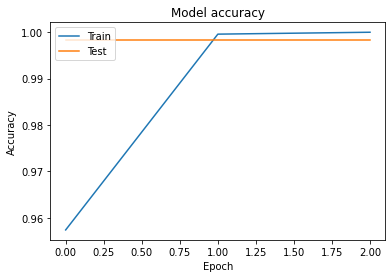

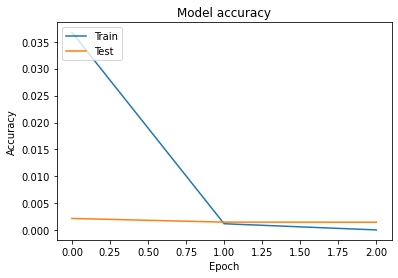

<Figure size 432x288 with 0 Axes>

In [87]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
save_fig('lstm_accuracy')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
save_fig('lstm_loss')

Precision, Recall & Confusion Matrix 👻

In [88]:
# precision, recall e confusion matrix
y_pred = model.predict_classes(X_test)
print('Precision on test set: ',metrics.precision_score(y_test,y_pred))
print('Recall on test set: ',metrics.recall_score(y_test,y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Precision on test set:  1.0
Recall on test set:  0.9912280701754386


Got 1.0 precision 🤯

In [92]:
!pip install scikit-plot

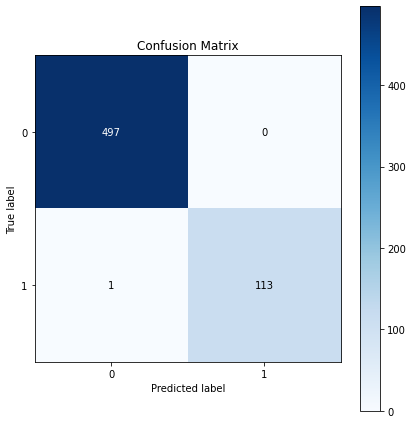

In [93]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test,
    y_pred,
    figsize=(6,6))
save_fig('confusion-matrix')